In [1]:
%load_ext autoreload
%autoreload 2
%cd ..
%cd ..

/home/daniel/Documents/vote-counts/src
/home/daniel/Documents/vote-counts


In [2]:
import pandas as pd
from pathlib import Path
import numpyro
from numpyro import distributions as dist
from numpyro.infer import NUTS, MCMC, Predictive
from jax import random, numpy as jnp
import matplotlib.pyplot as plt
import seaborn as sns

path_data = Path("data")
path_raw_data = path_data / "raw_data"

In [3]:
data = pd.read_csv(path_raw_data / "LOCAL_precinct_general.csv")

/tmp/ipykernel_755833/2543796059.py:1: DtypeWarning: Columns (2,3,11) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv(path_raw_data / "LOCAL_precinct_general.csv")


In [4]:
# pd.MultiIndex.from_product([data["precinct"], data["office"]])
data.groupby(["precinct", "office", "candidate"]).sum("votes")

votes   
precinct                         office                    candidate                   
# AB - CENTRAL ABSENTEE PRECINCT CHAIRMAN - SCHOOL BOARD   ALYSON SATTERWHITE   9283  \
                                                           BABUR LATEEF         9963   
                                                           STANLEY BENDER       2178   
                                                           WRITEIN               243   
                                 CLERK OF COURT            CHERYL EDMONDSTON      94   
...                                                                              ...   
ZUMBROTA TWP.                    COUNTY SHERIFF            PAUL GIELAU           157   
                                                           WRITEIN                 0   
                                 SOIL AND WATER SUPERVISOR DONALD SCHLIEP        281   
                                                           MARK COMSTOCK         274   
                                                           WRITEIN                 4   

                                                                               county_fips   
precinct                         office                    candidate                         
# AB - CENTRAL ABSENTEE PRECINCT CHAIRMAN - SCHOOL BOARD   ALYSON SATTERWHITE        51153  \
                                                           BABUR LATEEF              51153   
                                                           STANLEY BENDER            51153   
                                                           WRITEIN                   51153   
                                 CLERK OF COURT            CHERYL EDMONDSTON         51029   
...                                                                                    ...   
ZUMBROTA TWP.                    COUNTY SHERIFF            PAUL GIELAU               27049   
                                                           WRITEIN                   27049   
                                 SOIL AND WATER SUPERVISOR DONALD SCHLIEP            27049   
                                                           MARK COMSTOCK             27049   
                                                           WRITEIN                   54098   

                                                                               jurisdiction_fips   
precinct                         office                    candidate                               
# AB - CENTRAL ABSENTEE PRECINCT CHAIRMAN - SCHOOL BOARD   ALYSON SATTERWHITE              51153  \
                                                           BABUR LATEEF                    51153   
                                                           STANLEY BENDER                  51153   
                                                           WRITEIN                         51153   
                                 CLERK OF COURT            CHERYL EDMONDSTON               51029   
...                                                                                          ...   
ZUMBROTA TWP.                    COUNTY SHERIFF            PAUL GIELAU                     27049   
                                                           WRITEIN                         27049   
                                 SOIL AND WATER SUPERVISOR DONALD SCHLIEP                  27049   
                                                           MARK COMSTOCK                   27049   
                                                           WRITEIN                         54098   

                                                                               magnitude   
precinct                         office                    candidate                       
# AB - CENTRAL ABSENTEE PRECINCT CHAIRMAN - SCHOOL BOARD   ALYSON SATTERWHITE        1.0  \
                                                           BABUR LATEEF              1.0   
                                          

In [5]:
def model_A1(voters=None, count_1=None):
  p = numpyro.sample("p", dist.Uniform(low=0, high=1))
  numpyro.sample("obs", dist.Binomial(total_count=voters, probs=p), obs=count_1)

In [6]:
# Start from this source of randomness. We will split keys for subsequent operations.
rng_key = random.PRNGKey(0)
rng_key, rng_key_ = random.split(rng_key)

# Run NUTS.
kernel = NUTS(model_A1)
num_samples = 2000
mcmc = MCMC(kernel, num_warmup=1000, num_samples=num_samples)
mcmc.run(
    rng_key_, voters = 500, count_1 = 200
)
mcmc.print_summary()
samples_1 = mcmc.get_samples()

sample: 100%|██████████| 3000/3000 [00:02<00:00, 1119.34it/s, 3 steps of size 1.31e+00. acc. prob=0.90]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
         p      0.40      0.02      0.40      0.37      0.44    625.38      1.00

Number of divergences: 0


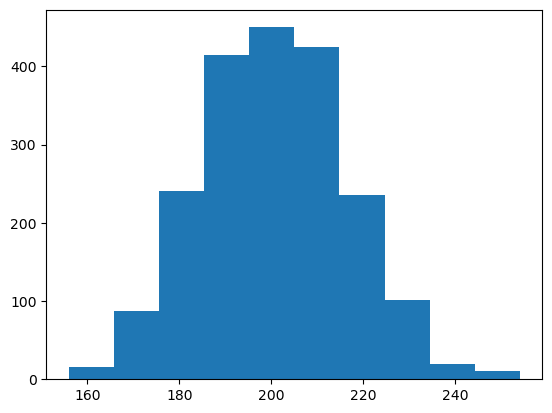

In [7]:
posterior_predictive_A1 = Predictive(model_A1, samples_1)
posterior_outcomes_A1 = posterior_predictive_A1(rng_key_, voters = 500)["obs"]
plt.hist(posterior_outcomes_A1)
plt.show()

In [8]:
def model_A2(voters=None, count_1=None):
  shape_1 = numpyro.sample("shape_1", dist.Exponential(rate=0.1))
  shape_2 = numpyro.sample("shape_2", dist.Exponential(rate=0.1))
  numpyro.sample("obs", dist.BetaBinomial(shape_1, shape_2, voters), obs=count_1)

In [9]:
# Start from this source of randomness. We will split keys for subsequent operations.
rng_key = random.PRNGKey(0)
rng_key, rng_key_ = random.split(rng_key)

# Run NUTS.
kernel = NUTS(model_A2)
num_samples = 2000
mcmc = MCMC(kernel, num_warmup=1000, num_samples=num_samples)
mcmc.run(
    rng_key_, voters = 500, count_1 = 200
)
mcmc.print_summary()
samples_A2 = mcmc.get_samples()

sample: 100%|██████████| 3000/3000 [00:03<00:00, 792.58it/s, 7 steps of size 2.72e-01. acc. prob=0.96]  


                mean       std    median      5.0%     95.0%     n_eff     r_hat
   shape_1      8.55      5.54      7.44      0.95     16.03    523.03      1.01
   shape_2     12.29      7.91     10.70      0.96     22.87    558.23      1.01

Number of divergences: 0


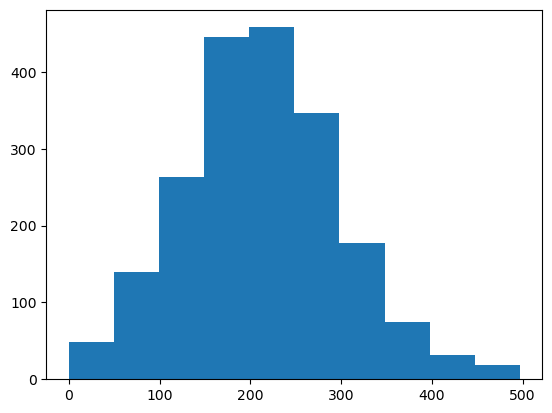

In [10]:
posterior_predictive_A2 = Predictive(model_A2, samples_A2)
posterior_outcomes_A2 = posterior_predictive_A2(rng_key_, voters = 500)["obs"]
plt.hist(posterior_outcomes_A2)
plt.show()

In [11]:
outcomes = jnp.concatenate([jnp.ones(200), jnp.zeros(300)])
def model_A3(n_voters =None, outcomes = None):
  pop_1 = numpyro.sample("pop_1", dist.Beta(2, 2))
  p_1 = numpyro.sample("p_1", dist.Uniform(low=0.5, high=1.0))
  p_2 = numpyro.sample("p_2", dist.Uniform(low=0.0, high=0.5))
  with numpyro.plate("data", n_voters) as ind:
    obs = outcomes[ind] if outcomes is not None else None
    numpyro.sample("outcomes", dist.MixtureSameFamily(dist.Categorical(jnp.stack([pop_1, 1 - pop_1])), dist.Bernoulli(jnp.stack([p_1, p_2]))), obs = obs)

In [12]:
# Start from this source of randomness. We will split keys for subsequent operations.
rng_key = random.PRNGKey(0)
rng_key, rng_key_ = random.split(rng_key)

# Run NUTS.
kernel = NUTS(model_A3)
num_samples = 5_000
mcmc = MCMC(kernel, num_warmup=1000, num_samples=num_samples)
mcmc.run(
    rng_key_, n_voters = len(outcomes), outcomes = outcomes
)
mcmc.print_summary()
samples_A3 = mcmc.get_samples()

sample: 100%|██████████| 6000/6000 [00:07<00:00, 788.66it/s, 19 steps of size 1.58e-01. acc. prob=0.93] 



                mean       std    median      5.0%     95.0%     n_eff     r_hat
       p_1      0.69      0.14      0.67      0.50      0.90   1943.43      1.00
       p_2      0.20      0.11      0.20      0.01      0.35   1831.56      1.00
     pop_1      0.41      0.16      0.40      0.15      0.69   1812.86      1.00

Number of divergences: 0


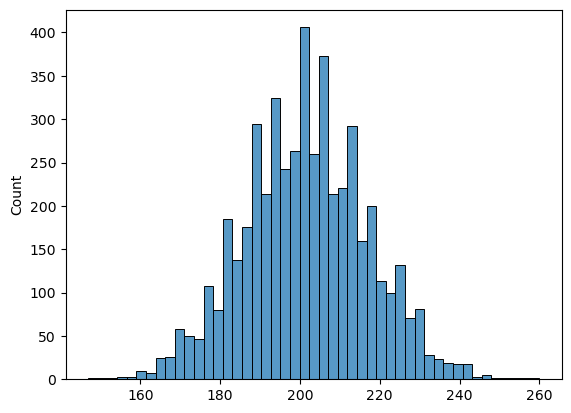

In [13]:
posterior_predictive_A3 = Predictive(model_A3, samples_A3)
posterior_samples = posterior_predictive_A3(rng_key_, n_voters = 500)
posterior_outcomes_A3 = posterior_samples["outcomes"].sum(axis = 1)
sns.histplot(posterior_outcomes_A3)
plt.show()

In [24]:
outcomes = jnp.stack(
    [
        jnp.concatenate([jnp.ones(200), jnp.zeros(300)]),
        jnp.concatenate([jnp.ones(250), jnp.zeros(250)]),
    ], axis = -1
)


def model_A4(n_voters=None, outcomes=None):
    pop_1 = numpyro.sample("pop_1", dist.Beta(2, 2))
    p_1 = numpyro.sample("p_1", dist.Uniform(low=jnp.full(2, 0.5), high=jnp.full(2, 1.0)))
    p_2 = numpyro.sample("p_2", dist.Uniform(low=jnp.full(2, 0.0), high=jnp.full(2, 0.5)))
    with numpyro.plate("voter", n_voters) as ind:
        obs = outcomes[ind] if outcomes is not None else None
        numpyro.sample(
            "outcomes",
            dist.MixtureSameFamily(
                dist.Categorical(jnp.stack([pop_1, 1 - pop_1])),
                dist.Bernoulli(jnp.stack([p_1, p_2])),
            ),
            obs=obs,
        )

In [25]:
# Start from this source of randomness. We will split keys for subsequent operations.
rng_key = random.PRNGKey(0)
rng_key, rng_key_ = random.split(rng_key)

# Run NUTS.
kernel = NUTS(model_A4)
num_samples = 2_000
mcmc = MCMC(kernel, num_warmup=1000, num_samples=num_samples)
mcmc.run(
    rng_key_, n_voters = len(outcomes), outcomes = outcomes
)
mcmc.print_summary()
samples_A4 = mcmc.get_samples()

ValueError: Incompatible shapes for broadcasting: shapes=[(500,), (2,)]